# First data exploration

### Extracting and cleaning plot summaries 

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import pipeline
from scipy.special import softmax


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

#Setting pandas display options
pd.set_option("max_colwidth", None)


from sentence_transformers import SentenceTransformer, util


#Src folder path
src_folder = 'src/data/'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mathieu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mathieu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
df_plot_summaries = pd.read_csv(src_folder + 'plot_summaries.txt', sep='\t', header=None,  names=['id', 'summary'])
df_plot_summaries.sample(2)

,id,summary
38263,25893786,"Danny , is a young student in middle school. He starts to develop feelings for his best friend, Julie. However a new student by the name of Archie comes in and sweeps Julie off her feet. Danny flees to the graveyard where his father is buried and talks to him about his problems. He soon comes across Hubbie alias The Ghost , who helps Danny with his girl problems. Hubbie, former living person from the 30's, gives Danny his advise. They backfire in many ways, always leaving Danny depressed. Danny soon learns that Hubbie once had a former lover before dying in an accident. Danny and Julie end up together at a school dance and Hubbie re-connects with his former love with the help of Danny."
18058,1666594,"In the year 1797, the British naval vessel HMS Avenger impresses a crewman ""according to the Rights of War"" from the merchant ship The Rights Of Man. The new crewman, Billy Budd, is considered naive by his shipmates, and they attempt to indoctrinate him in their cynicism. But Budd's steadfast optimism is impenetrable, as when he is asked to critique the horrible gruel the crew must eat, he offers ""It's hot. And there's a lot of it. I like everything about it except the flavor."" Though Budd manages to enchant the crew, his attempts at befriending the brutal master-at-arms, John Claggart, are unsuccessful. Claggart is cruel and unrepentant, a man who believes he must control the crew through vicious flogging; savaging them before they can prey on him. He reveals his mistrust for humanity when Budd confronts him about his discipline. Budd: ""It's wrong to flog a man. It's against his being a man."" Claggart: ""The sea is calm you said. Peaceful. Calm above, but below a world of gliding monsters preying on their fellows. Murderers, all of them. Only the strongest teeth survive. And who's to tell me it's any different here on board, or yonder on dry land?"" Claggart orders Squeak to find means of putting Budd on report and to implicate him in a planned mutiny. He then brings his charges to the Captain, Edwin Fairfax Vere. Although Claggart has no reason to implicate Budd in the conspiracy, Budd becomes a target because Billy represents everything that Claggart despises: humility, innocence, and trust in humanity. Vere summons both Claggart and Budd to his cabin for a private confrontation. When Claggart makes his false charges that Budd is a conspirator, the accused is unable to find the words to respond and he strikes Claggart, killing him with a single blow. Captain Vere assembles a court-martial. Vere and all the other officers on board are fully aware of Budd's simplicity and Claggart's evil, but the captain is also torn between his morality and duty to his station. Vere intervenes in the final stages of deliberations . He argues the defendant must be found guilty for even striking Claggart, Budd's superior, not to mention killing him. His arguments to pursue the letter of the law succeed, and Budd is convicted. Condemned to be hanged from the ship's yardarm at dawn the following morning, Budd takes care to wear his good shoes. At Budd's final words, ""God bless Captain Vere!"", Vere crumbles, and Billy is subsequently hoisted up and hanged. At this point the crew is on the verge of mutiny over the incident, but Vere can only stare off into the distance, the picture of abdication, overtaken by his part in the death of innocence. Just as the crew is to be fired upon, a French vessel appears and commences cannon fire on the Avenger, and the crew eventually returns fire. HMS Avenger fends off the attack, but in the course of battle a piece of the ship's rigging falls on Vere, killing him in an act of poetic justice."


Some cleaning is necessary for the plot summaries. There appears to be in the data:

1) {{annotation}}
2) links (references to wikipedia)
3) <> html delimiters
4) ... further inspection needed

That need to be removed


In [4]:
def clean_plot(txt):

    #Remove URLs
    txt = re.sub(r"http\S+|www\.\S+", '', txt)

    #Remove HTML tags
    txt = re.sub(r'<.*?>', '', txt)

    #Remove {{annotations}}
    txt = re.sub(r'\{\{.*?\}\}', '', txt)

    #Remove the ([[ annotation that is never closed
    txt = re.sub(r'\(\[\[', '', txt)

    #Remove the synopsis from context
    txt = re.sub(r'Synopsis from', '', txt)

    #Remove <ref...}} tags
    txt = re.sub(r'<ref[^}]*}}', '', txt)

    return txt

In [5]:
df_test_clean = df_plot_summaries.copy()
df_test_clean["summary"] = df_plot_summaries['summary'].apply(clean_plot)
df_test_clean.sample(2)

,id,summary
41432,9743605,"A South Seas island prince is wrongly convicted of murder and executed by having a knife driven into his heart. The prince is buried in a hollow tree trunk and forgotten about until nuclear radiation reanimates it in the form of the tobonga, a scowling tree stump. The monster escapes from the laboratory and murders several people, including the true murderer . The creature cannot be stopped, burned, or trapped. Only when a crack rifle shot drives the knife all the way through its heart it finally dies and sinks into the swamp. A pair of American scientists save the day."
27680,5307150,"The movie follows the events and hardships suffered by the nine companies, roughly 550 men, of the United States Army 77th Infantry Division that had been completely cut off and surrounded by German forces a short distance away in the Argonne Forest. The force was led by Maj. Charles W. Whittlesey, who was disparagingly described as a ""New York lawyer"" by his commanders. The battalion was part of what was supposed to be a three-pronged attack through the German lines. The battalion believed another American force was on its right flank and a French force on its left, not knowing that they had both retreated. The battalion lost contact with headquarters. Whittlesey sent several runners to headquarters, but none of them returned. He ended up having to rely on carrier pigeons to communicate. During the siege, American artillery began firing on the German position in the forest as the Americans cheered. However, the artillery began falling on the American line, killing numerous men in friendly fire. Whittlesey sends a pigeon to headquarters with a message saying they were being hit by their own artillery, saying, ""For heaven's sake, stop it"". The headquarters receives the message and stops firing. Witnessing the incident, the Germans attack the disoriented American force, but they are repelled by the Americans in fierce fighting and retreat back to their trenches. After several days and numerous repelled attacks, the Americans are still holding on, despite desperately low supplies, forcing them to reuse bandages and other medical supplies and take food off dead soldiers. The Germans capture two Americans, one of them severely wounded, and begin using them to try to negotiate with Whittlesey. The uninjured prisoner receives good treatment from a German officer who speaks fluent English after having lived in America for several years. He tries to convince the prisoner that there is no hope, to which the American responds, ""They'll never surrender."" The American eventually agrees to bring a message from the Germans to Whittlesey urging surrender after his captor says he wants to save lives. The Germans then send him escorted by a German soldier with a white flag back to the American line with the message. Whittlesey responds by throwing the flag back towards the Germans. The Americans continue to hold despite relentless attacks and low supplies. Eventually, an American pilot is sent out to search for the force, and flies right over their position. Realizing it is an American plane, the Americans make noise to try to get the pilot's attention. The Germans prepare to shoot at the plane, but their commander tells them to hold their fire because if the pilot knew the Germans' location he would also know the Americans'. The pilot locates the Americans and signals to them, and the Germans begin firing at him. The pilot is critically wounded, but manages to circle the location on his map and navigate back to the airfield, dead by the time he lands. The men at the base see his map and bring it back to headquarters. After six days, reinforcements finally arrive at the American lines. Major General Robert Alexander arrives in a car, telling Whittlesey there will be ""commendations and promotions for everyone"". Whittlesey is furious about the debacle, and is further angered by Alexander's insistence that the casualties they suffe

    histogram of the length of the summary

### check if we need to webscrap some summary from internet (if the summary is too short)

In [20]:
df_length_summary = df_test_clean['summary'].copy(deep=True)
df_length_summary = df_length_summary.apply(len) 


Text(0.5, 1.0, 'Distribution of the length of the summary')

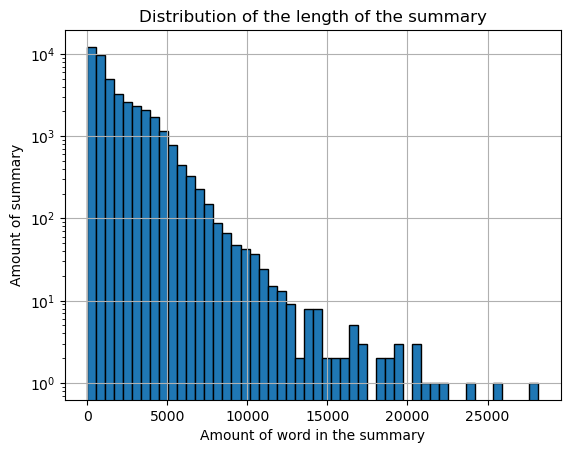

In [25]:
df_length_summary.hist(bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Amount of word in the summary')
plt.ylabel('Amount of summary')
plt.title('Distribution of the length of the summary')

Text(0.5, 1.0, 'Distribution of the summary that have length <= 1000')

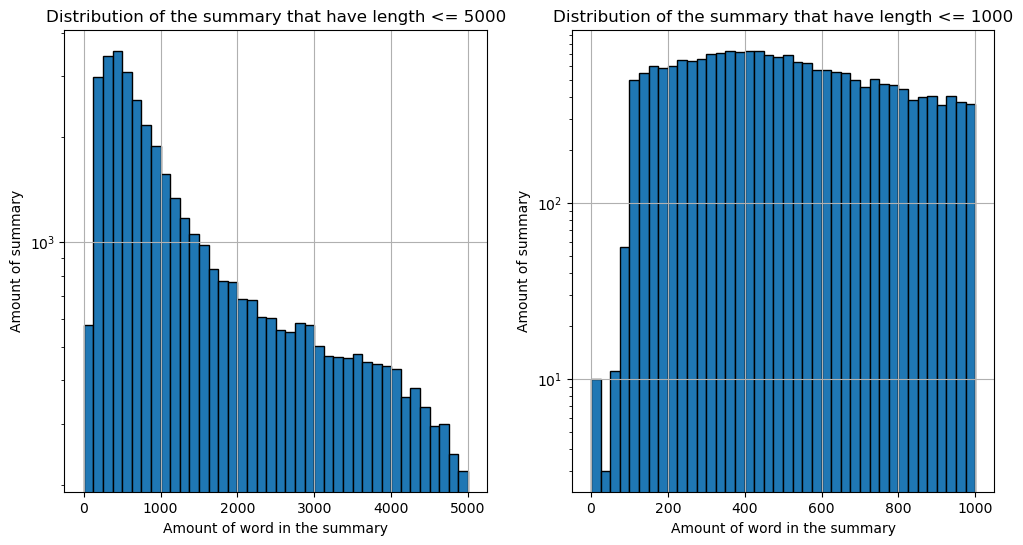

In [43]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.ravel()

df_length_summary_below_5000 = df_length_summary[df_length_summary <= 5000]
df_length_summary_below_5000.hist(bins=40, edgecolor='black', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('Amount of word in the summary')
axes[0].set_ylabel('Amount of summary')
axes[0].set_title('Distribution of the summary that have length <= 5000')


df_length_summary_below_1000 = df_length_summary[df_length_summary <= 1000]
df_length_summary_below_1000.hist(bins=40, edgecolor='black', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('Amount of word in the summary')
axes[1].set_ylabel('Amount of summary')
axes[1].set_title('Distribution of the summary that have length <= 1000')

#### Sentiment analysis test

I see two possibilities: making classical sentiment analysis using twitter-roberta-base-sentiment trained on tweets or using distilbert-base-uncased-emotions for emotions

In [9]:
#First possibility: sentence by sentence sentiment classification

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)



dict_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
for t in df_test_clean['summary'].sample(1):
    for sentence in nltk.sent_tokenize(t):
        print(sentence)
        t_encoded = tokenizer(sentence, return_tensors='pt')
        t_output = model(**t_encoded)
        t_scores = softmax(t_output.logits.detach().numpy(), axis=1)
        t_predicted = np.argmax(t_scores)
        print(dict_labels[t_predicted], t_scores[0][t_predicted])
    

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mathieu\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment-latest. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-

The story is about three sisters Srividya, Subha and Jayachitra, each getting attracted to their tenant, a young man played by Sivakumar.
neutral 0.8701348
Sivakumar falls in love with Jayachitra.
neutral 0.5637661
However, things take a turn to the worse in the typical Balachander style when Jayachitra sacrifices herself to the whims of a playboy, played by Kamal Haasan in order to save her friend  from his exploits.
negative 0.77866256
What happens next, who marries whom, is the crux of a dramatic climax.
neutral 0.84232396
The movie turns the entire concept of romantic movies by its head - the concept being that the hero does not always have to get the girl.
neutral 0.6040655


In [10]:
# Second possibility: sentence to sentence emotion classification

#the emotions are anger, fear, joy, love, sadness, surprise and neutral

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

for t in df_test_clean['summary'].sample(1):
    for sentence in nltk.sent_tokenize(t):
        print(sentence)
        out = classifier(sentence)[0]
        best_emotion_dict = max(out, key=lambda x: x['score'])
        best_label = best_emotion_dict['label']
        best_score = best_emotion_dict['score']
        print(best_label, best_score)    

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mathieu\.cache\huggingface\hub\models--j-hartmann--emotion-english-distilroberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_cla

An extremist right-wing candidate is elected to the French presidency, sparking riots in Paris.
anger 0.5820716023445129
Hoping to escape Paris but needing cash, Alex, Tom, Farid, the pregnant Yasmine, and her brother Sami take advantage of the chaos to pull off a robbery.
fear 0.4334038197994232
Sami is shot and the group splits up: Alex and Yasmine take Sami to a hospital, and Tom and Farid take the money to a family-run inn near the border.
sadness 0.7484657764434814
Innkeepers Gilberte and Klaudia claim their rooms are free and seduce the two men.
neutral 0.6540887951850891
At the hospital, the emergency room staff report Sami's injury to the police.
sadness 0.7390162944793701
Sami insists Yasmine run before the police catch her.
neutral 0.45305579900741577
His dying wish is that Yasmine not have an abortion.
sadness 0.9689406156539917
Alex and Yasmine flee, phoning their friends for directions to the inn.
fear 0.48608505725860596
Tom and Farid give them directions but soon after a

In [55]:
#keep small summary to test the segmentation
df_test_clean_with_length = df_test_clean.copy(deep=True)
df_test_clean_with_length['length'] = df_test_clean_with_length['summary'].apply(len) 
df_test_clean_with_length = df_test_clean_with_length[df_test_clean_with_length['length'] < 150]
df_test_clean_with_length.head(5)

,id,summary,length
39,28238240,"Mickey and the Scorpions decide to go on a big game hunt. The kids go out into the woods, only find themselves up against real wild animals .",141
55,27975390,"Reportedly, the film is about slum kids who are trained for a dance competition.Shaimak Davar in a director's avatar",116
116,33837735,"Emilio di Roccanera, The Black Corsair, seeks revenge against Governor Van Guld for the murder of his family.",109
184,27997130,Three young Russians from very different walks of life involutarily enter the military to escape their past.,108
198,9916623,"Butte Morgan plans to take over the circus my marrying Maria Wallace. She, however, is interested only in the trick rider Jack Grant.",134


In [45]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

df_summary = df_test_clean_with_length['summary']
# Exemple de résumé (ce texte serait votre résumé complet de film)
summary = """
The story begins with the protagonist arriving in a new town. He feels out of place at first, but soon makes friends. 
As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest. 
This leads to a series of challenges that test his resolve. 
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.
"""

# 1. Diviser le résumé en phrases
sentences = summary.split(". ")
sentences = [s.strip() for s in sentences if s]  # Supprimer les espaces et les phrases vides

# 2. Obtenir les embeddings de chaque phrase
embeddings = model.encode(sentences)

# 3. Calculer les similarités cosinus entre phrases successives
similarities = [util.pytorch_cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]

# 4. Identifier les points de transition basés sur un seuil de similarité
threshold = 0.5  # Par exemple, une similarité inférieure à 0.5 indique un changement de thème
segments = []
current_segment = [sentences[0]]

for i, similarity in enumerate(similarities):
    if similarity < threshold:  # Si la similarité est faible, cela peut indiquer une transition
        segments.append(" ".join(current_segment))  # Ajouter le segment actuel à la liste
        current_segment = []  # Réinitialiser pour un nouveau segment
    current_segment.append(sentences[i + 1])

segments.append(" ".join(current_segment))  # Ajouter le dernier segment

# 5. Afficher les segments
for idx, segment in enumerate(segments):
    print(f"Segment {idx+1}:\n{segment}\n")

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mathieu\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Segment 1:
The story begins with the protagonist arriving in a new town

Segment 2:
He feels out of place at first, but soon makes friends As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest

Segment 3:
This leads to a series of challenges that test his resolve

Segment 4:
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.



In [128]:
# Second possibility: sentence to sentence emotion classification

#the emotions are anger, fear, joy, love, sadness, surprise and neutral

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

for t in df_test_clean['summary'].sample(1):
    for sentence in nltk.sent_tokenize(t):
        print(sentence)
        out = classifier(sentence)[0]
        best_emotion_dict = max(out, key=lambda x: x['score'])
        best_label = best_emotion_dict['label']
        best_score = best_emotion_dict['score']
        print(best_label, best_score)    

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Lava and Kusa were born to mother Sita at Sage Valmiki’s hermitage; they grew up learning the essence of Ramayana and master the art of war by using divine weapons from the guidance of Sage Valmiki.
neutral 0.6792468428611755
The story goes on with their thrilling childhood experiences blended with action, comedy and enchanting magical powers.
joy 0.9488742351531982
The role of gigantic falcon, squirrels, monkeys, rabbits and tortoises delights not only the children but also to all age groups.
disgust 0.49034014344215393
On invitation the twins set off to Ayodhya to recite Valmiki Ramayana in front of the King Rama.
neutral 0.7610857486724854
The story turns gripping as the twins learn that Mata Sita was sent to vanvas by Lord Rama.
fear 0.3607124984264374
They return from Ayodhya with anger and rage over lord Rama.
anger 0.9758801460266113
Lord Rama performs Aswamedha yagna for the properity of his kingdom and sets off a horse , which encounters with Lava Kusa finally.
neutral 0.88317

In [79]:
#try to segment the text in a more clever way I guess?
from sentence_transformers import SentenceTransformer, util
nltk.download('punkt')  # Télécharge le tokenizer nécessaire pour les phrases

# Initialisation du modèle de classification d'émotions
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# Initialisation du modèle de similarité de phrases
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Exemple de résumé (ou utilisez df_test_clean_with_length['summary'] pour appliquer à tout le dataset)
summary = """
The story begins with the protagonist arriving in a new town. He feels out of place at first, but soon makes friends. 
As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest. 
This leads to a series of challenges that test his resolve. 
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.
"""

# 1. Diviser le résumé en phrases
sentences = nltk.sent_tokenize(summary)  # Utiliser nltk pour la tokenisation des phrases
sentences = [s.strip() for s in sentences if s]  # Supprimer les espaces et les phrases vides

# 2. Obtenir les embeddings de chaque phrase
embeddings = model.encode(sentences)

# 3. Calculer les similarités cosinus entre phrases successives
similarities = [util.pytorch_cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]

# 4. Identifier les points de transition basés sur un seuil de similarité
threshold = 0.5  # Par exemple, une similarité inférieure à 0.5 indique un changement de thème
segments = []
current_segment = [sentences[0]]

for i, similarity in enumerate(similarities):
    if similarity < threshold:  # Si la similarité est faible, cela peut indiquer une transition
        segments.append(" ".join(current_segment))  # Ajouter le segment actuel à la liste
        current_segment = []  # Réinitialiser pour un nouveau segment
    current_segment.append(sentences[i + 1])

segments.append(" ".join(current_segment))  # Ajouter le dernier segment

# 5. Analyser les émotions de chaque segment et afficher les résultats
best_emotions = []
emotionsS = []
for idx, segment in enumerate(segments):
    print(f"Segment {idx+1}:\n{segment}\n")
    
    # Classifier les émotions pour chaque segment
    emotions = classifier(segment)[0]
    emotionsS.append(emotions)
    best_emotion = max(emotions, key=lambda x: x['score'])  # Sélectionner l'émotion avec le score le plus élevé
    best_emotions.append(best_emotion)
    # Afficher l'émotion dominante pour le segment
    print(f"Emotion dominante pour le Segment {idx+1}: {best_emotion['label']} : {best_emotion['score']:.2f}\n")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mathieu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Segment 1:
The story begins with the protagonist arriving in a new town.

Emotion dominante pour le Segment 1: neutral : 0.62

Segment 2:
He feels out of place at first, but soon makes friends. As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest.

Emotion dominante pour le Segment 2: disgust : 0.68

Segment 3:
This leads to a series of challenges that test his resolve.

Emotion dominante pour le Segment 3: neutral : 0.83

Segment 4:
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.

Emotion dominante pour le Segment 4: neutral : 0.66



In [147]:
emotions = np.array([best_em['label'] for best_em in best_emotions])
scores = np.array([best_em['score'] for best_em in best_emotions])


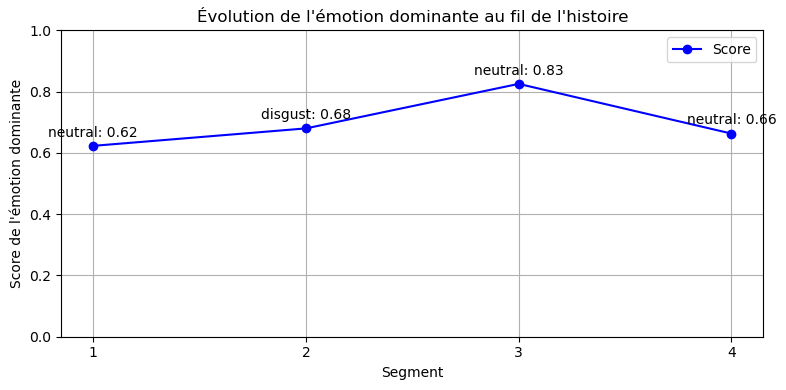

In [148]:

# Créer une liste de numéros de segment pour l'axe x
x = list(range(1, len(segments) + 1))

# Tracer les scores pour chaque segment
plt.figure(figsize=(8, 4))
plt.plot(x, scores, marker='o', linestyle='-', color='b', label='Score')

# Ajouter des annotations pour chaque point (émotion dominante)
for i, (emotion, score) in enumerate(zip(emotions, scores), start=1):
    plt.text(i, score + 0.02, f'{emotion}: {score:.2f}', ha='center', va='bottom')
# Configurer le graphique
plt.ylim(0, 1)
plt.xlabel('Segment')
plt.ylabel('Score de l\'émotion dominante')
plt.title('Évolution de l\'émotion dominante au fil de l\'histoire')
plt.xticks(x)  # Afficher les numéros de segment sur l'axe x
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


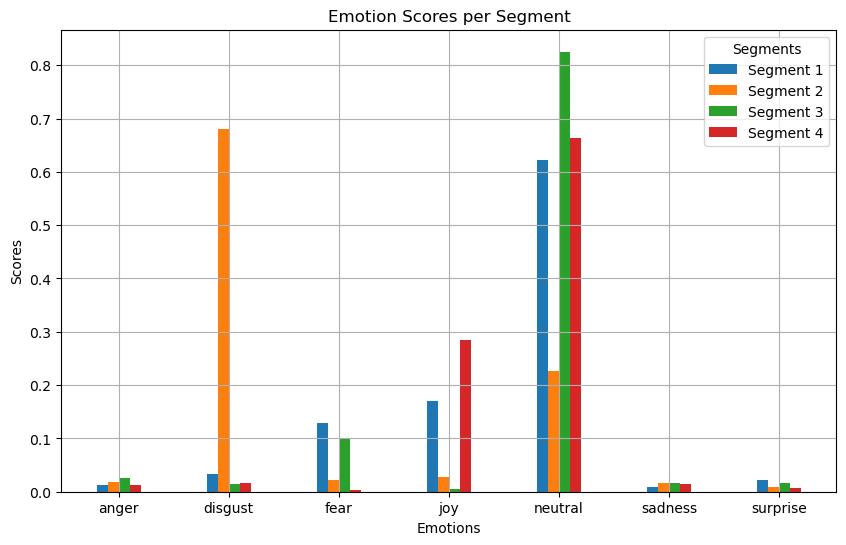

In [104]:

# Extract the list of emotions from the first segment
emotions = [entry['label'] for entry in emotionsS[0]]

# Extract scores for each emotion in each segment
scores = []
for segment in data:
    segment_scores = [entry['score'] for entry in segment]
    scores.append(segment_scores)

fig, ax = plt.subplots(figsize=(10, 6))

num_segments = len(data)
bar_width = 0.1

indices = np.arange(len(emotions))

for i in range(num_segments):
    ax.bar(indices + i * bar_width, scores[i], width=bar_width, label=f'Segment {i+1}')

# Set x-ticks in the middle of each group of bars
ax.set_xticks(indices + bar_width * (num_segments - 1) / 2)
ax.set_xticklabels(emotions)

# Add labels and title
ax.set_xlabel('Emotions')
ax.set_ylabel('Scores')
ax.set_title('Emotion Scores per Segment')
ax.legend(title='Segments')
plt.grid(True)

plt.show()


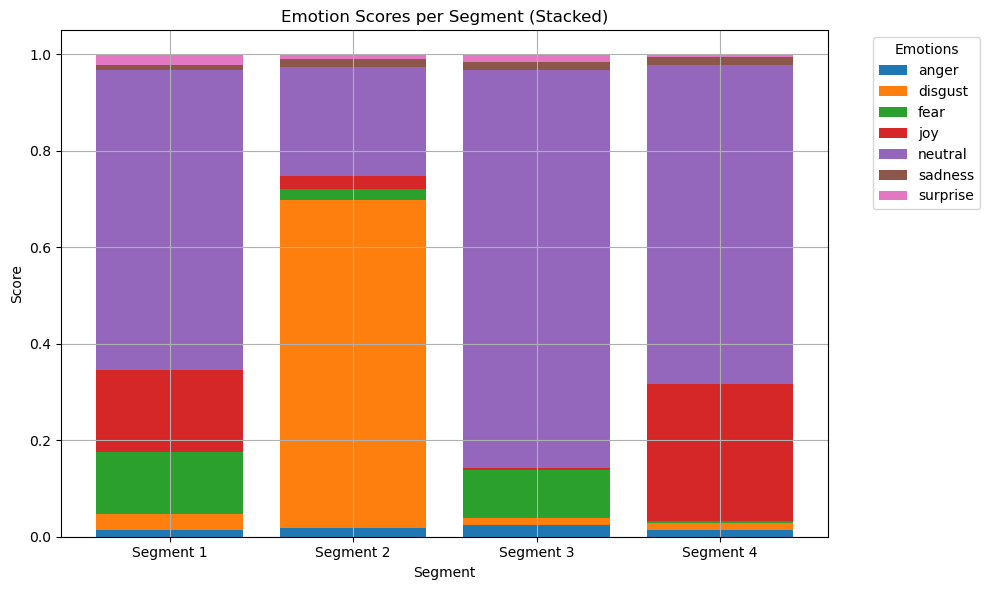

In [103]:
emotions = [entry['label'] for entry in emotionsS[0]]
scores_by_emotion = {emotion: [] for emotion in emotions}

for segment in data:
    for entry in segment:
        scores_by_emotion[entry['label']].append(entry['score'])

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(1, len(data) + 1)  # x positions for the bars (1, 2, 3, ...)

bottom = np.zeros(len(data))  # Initialize the bottom for stacking
for emotion in emotions:
    scores = scores_by_emotion[emotion]
    bars = ax.bar(x, scores, bottom=bottom, label=emotion)
    bottom += scores

ax.set_xlabel('Segment')
ax.set_ylabel('Score')
ax.set_title('Emotion Scores per Segment (Stacked)')
ax.set_xticks(x)
ax.set_xticklabels([f'Segment {i}' for i in x])
ax.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()

plt.show()


In [116]:
df_metadata = pd.read_csv(src_folder + 'movie.metadata.tsv', sep='\t', header=None,
                                    names=['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 
                                            'Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime',
                                            'Movie_languages_(Freebase ID:name tuples)', 'Movie_countries_(Freebase ID:name tuples)',
                                           'Movie_genres_(Freebase ID:name tuples)'])

In [144]:

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Define a function to process each summary into segments and get emotion scores
def process_summary(summary, threshold=0.5):
    # Split the summary into sentences
    sentences = nltk.sent_tokenize(summary)
    sentences = [s.strip() for s in sentences if s]  # Remove empty sentences
    
    # Get embeddings and calculate similarities
    embeddings = model.encode(sentences)
    similarities = [util.pytorch_cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]
    
    # Split into segments based on similarity threshold
    segments = []
    current_segment = [sentences[0]]
    
    for i, similarity in enumerate(similarities):
        if similarity < threshold:
            segments.append(" ".join(current_segment))
            current_segment = []
        current_segment.append(sentences[i + 1])
    
    segments.append(" ".join(current_segment))  # Add the last segment

    # Get emotion scores for each segment
    segment_data = []
    for segment in segments:
        emotion_scores = {emotion['label']: emotion['score'] for emotion in classifier(segment)[0]}
        segment_data.append(emotion_scores)
    
    # Create DataFrame for this summary
    df_summary = pd.DataFrame(segment_data)
    return df_summary

# Assuming you have a main DataFrame df_summaries with a 'summary' column
# Process each summary and store the result as a dictionary of DataFrames
summary_dfs = {}  # To store DataFrames for each summary
df_summaries = df_test_clean.copy(deep=True).iloc[:100]
for idx, row in tqdm(df_summaries.iterrows()):
    summary_text = row['summary']
    df_summary = process_summary(summary_text)
    summary_dfs[idx] = df_summary  # Save the DataFrame by index or summary ID

# Display an example DataFrame for the first summary
summary_dfs

100it [01:23,  1.19it/s]


{0:       anger   disgust      fear      joy   neutral  sadness  surprise
 0  0.100081  0.094817  0.049915  0.02779  0.245066  0.01221  0.470121,
 1:        anger   disgust      fear       joy   neutral   sadness  surprise
 0   0.015594  0.161295  0.003804  0.017403  0.669111  0.106349  0.026444
 1   0.505421  0.056697  0.015248  0.006627  0.368072  0.042318  0.005617
 2   0.147101  0.073540  0.001699  0.025683  0.691569  0.053160  0.007249
 3   0.007609  0.011425  0.006654  0.722332  0.214251  0.011099  0.026629
 4   0.045254  0.212036  0.006107  0.098514  0.599974  0.032596  0.005518
 5   0.004387  0.013430  0.001089  0.035245  0.851223  0.024317  0.070310
 6   0.019375  0.165094  0.032803  0.015686  0.716833  0.037243  0.012966
 7   0.010372  0.019969  0.049723  0.005329  0.863677  0.042711  0.008218
 8   0.007307  0.002146  0.006143  0.061057  0.054396  0.004984  0.863967
 9   0.956550  0.016159  0.002040  0.000480  0.019219  0.002098  0.003454
 10  0.028410  0.059790  0.004506  0.

A partir de ça, essayer de faire une regression linéaire avec ces valeurs et le box office?

In [127]:
df_summary_box_office = pd.concat([df_test_clean['summary'], df_metadata['Movie_box_office_revenue']], axis=1)
print(df_summary_box_office.shape)
df_summary_box_office.dropna(axis=0, inplace=True)
df_summary_box_office.shape

(81741, 2)


(4392, 2)

    Beaucoup de film n'ont pas de box office => bien de webscraper ça